# Flower Classification Project

<img src="nb_img.jpg" alt="Sample Flower" style="width: 100%; height: auto;">

This project focuses on building a machine learning pipeline for classifying flower images into predefined categories. The goal is to develop a robust deep learning model capable of accurately predicting the flower type based on input images. The project follows a structured workflow encompassing data preprocessing, augmentation, model training, evaluation, and visualization.
                                                                                                                                                                                                                                                                                                                            

---

## Flower Classification Project

This project focuses on building a machine learning pipeline for classifying flower images into predefined categories. The goal is to develop a robust deep learning model capable of accurately predicting flower types based on input images. The workflow encompasses data collection, preprocessing, augmentation, model training, evaluation, and deployment.

### Key Steps and Components

1. **Dataset Search and Preparation**:
   - The dataset was sourced from Kaggle, chosen for its cleanliness, diversity, and well-organized structure. 
   - To enhance the robustness of the model, an additional **"unknown"** class was created. This class included images of non-target flowers and unrelated items, enabling the model to handle out-of-distribution inputs and reduce false positive classifications.
   - Images were organized into class-specific directories for ease of training and testing.

2. **Data Augmentation**:
   - Various transformations, such as flipping, rotation, cropping, and color adjustments, were applied to improve generalization and address class imbalances.

3. **Model Architecture**:
   - A state-of-the-art deep learning model, **MobileNetV3**, was employed for classification.
   - Transfer learning was applied, leveraging pretrained weights to provide a strong starting point for training.

4. **Training Strategy**:
   - The dataset was split into training and validation sets.
   - The training pipeline included advanced optimization techniques like learning rate scheduling and early stopping to prevent overfitting.

5. **Evaluation and Visualization**:
   - Key performance metrics such as accuracy, F1-score, and loss were analyzed to assess model performance.
   - Predictions were visualized to better understand classification quality and identify potential areas for improvement.

6. **Model Deployment**:
   - The trained model was exported to ONNX format for deployment, ensuring compatibility and scalability for real-world applications.

### Summary

This structured approach, combining clean dataset acquisition, robust augmentation, and cutting-edge modeling techniques, demonstrates how to tackle a real-world image classification problem effectively. The inclusion of an "unknown" class significantly enhanced the model's ability to generalize and reject incorrect classifications, a critical feature for practical deployment. By following this pipeline, the project bridges the gap between machine learning and real-world challenges in flower identification.
 and techniques.
entification.
 and techniques.


---

## The Importance of Flower Classification

Flower classification plays a vital role in understanding and preserving biodiversity. By identifying different species, we can protect endangered plants, support ecosystems, and enhance agricultural practices. Accurate classification also aids in discovering medicinal compounds and monitoring environmental changes.

In the era of AI, automated flower classification accelerates research, conservation, and education, connecting technology with nature. Each classified flower contributes to a deeper understanding of the intricate balance of life on Earth.


---

## Searching for the Dataset
The dataset used for this project was sourced from Kaggle, a popular platform for datasets and machine learning competitions. Kaggle offers a wide variety of high-quality datasets, making it an excellent starting point for data exploration. After evaluating multiple options, a flower classification dataset was chosen based on the following criteria:

- **Cleanliness**: The dataset was well-organized and free of noisy or irrelevant images, reducing the need for extensive preprocessing.
- **Diversity**: It included images from various flower species, ensuring robust training.
- **Quality**: High-resolution images suitable for deep learning tasks.
- **Structure**: Organized format with separate folders for each class, simplifying the training pipeline.

Additionally, to improve robustness, a new **"unknown"** class was created by collecting unrelated or non-target flower images. This allowed the model to better handle out-of-distribution inputs and reduce false positive classifications.

By selecting a clean and ready-to-use dataset, and supplementing it with custom "unknown" class data, the project avoided unnecessary preprocessing overhead while significantly enhancing model performance.raining.


## Dataset Overview
The dataset contains images of [5] flower species, with average: [550] images per category. Below is a visualization of the class distribution:

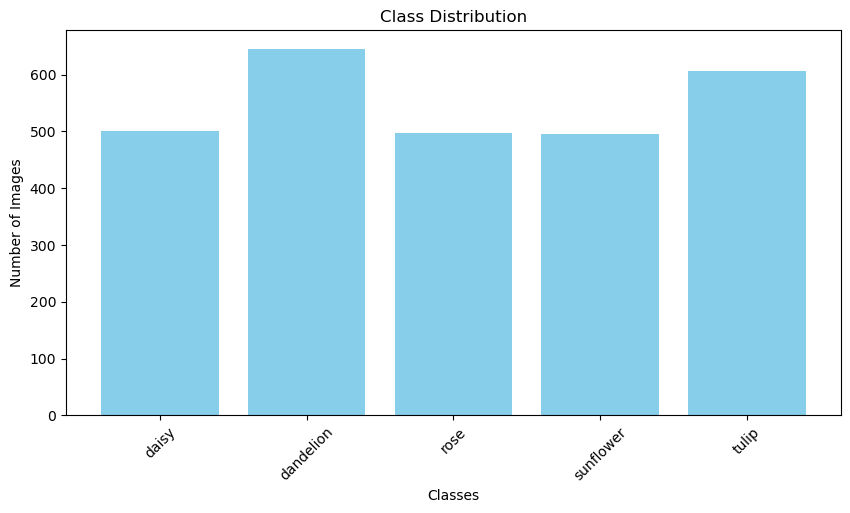

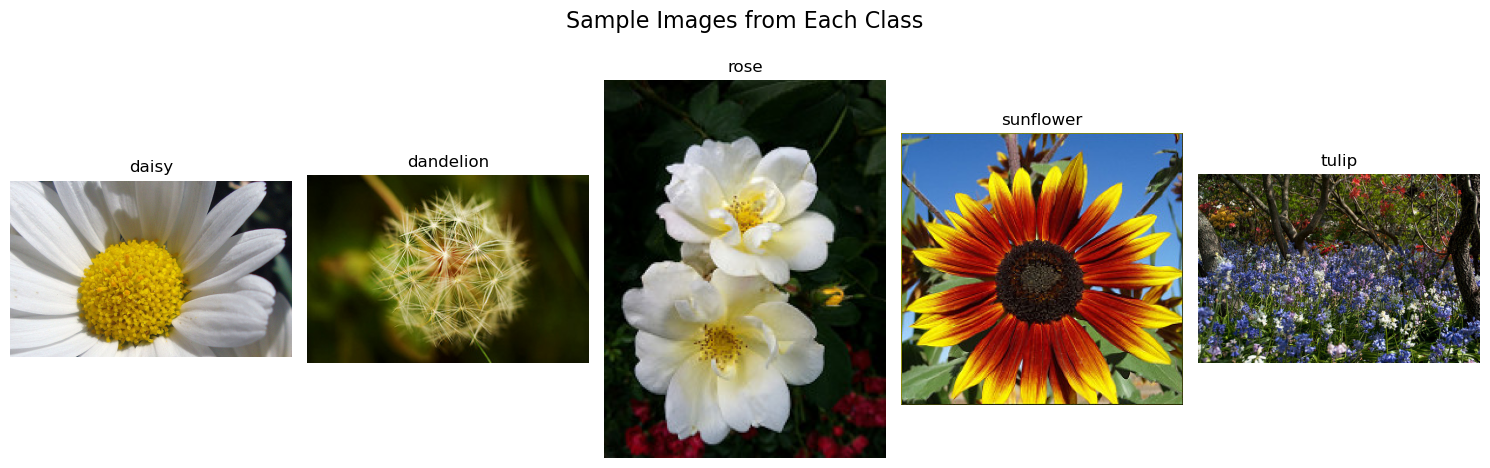

In [1]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# Define the dataset directory
data_dir = r"train"

# Get class counts
classes = os.listdir(data_dir)
class_counts = {cls: len(glob(os.path.join(data_dir, cls, "*.jpg"))) for cls in classes}

# Bar chart visualization
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Visualize sample images from each class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    sample_img_path = glob(os.path.join(data_dir, cls, "*.jpg"))[0]
    img = Image.open(sample_img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(cls)
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


---

## Data Augmentation

To improve the generalization of the model and enhance the training dataset, several augmentation techniques were applied:
- **Flipping**: Horizontal and vertical flips to increase orientation variability.
- **Rotation**: Random rotation to make the model more robust to positional changes.
- **Scaling and Cropping**: Adjust image size while preserving key features.
- **Color Adjustments**: Variations in brightness, contrast, and saturation to mimic different lighting conditions.

Below is an example of augmented images generated from a single original image:


In [2]:
import os
import torch
from glob import glob
from torchvision import transforms as T
from PIL import Image
from tqdm import tqdm
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

# إعداد عشوائية ثابتة لضمان تكرار النتائج
random.seed(2024)
torch.manual_seed(2024)

# تعريف Dataset مخصص
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        self.im_paths = glob(os.path.join(root, "*", "*"))  # تحميل كل الصور داخل الفئات
        self.classes = sorted(os.listdir(root))  # أسماء الفئات
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # تحويل الفئة إلى رقم

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        try:
            img = Image.open(im_path).convert("RGB")  # فتح الصورة
            label = os.path.basename(os.path.dirname(im_path))  # اسم الفئة
            return img, label
        except Exception as e:
            print(f"Error loading image {im_path}: {e}")
            return None, None

# دالة Augmentation
def create_augmentation():
    return T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.3),
        T.RandomRotation(degrees=random.randint(10, 45)),
        T.ColorJitter(
            brightness=0.5,
            contrast=0.6,
            saturation=0.7,
            hue=0.2
        ),
        T.RandomAffine(
            degrees=15,
            translate=(0.1, 0.2)
        ),
        T.RandomPerspective(distortion_scale=0.5, p=0.5),
        T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
        T.RandomCrop(224, padding=10),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# حفظ الصور بعد Augmentation
def save_augmented_images(img, label, label_dir, idx, multiplier):
    for i in range(multiplier):
        augmented_img = create_augmentation()(img)
        augmented_img_path = os.path.join(label_dir, f"aug_{idx}_{i}.jpg")
        T.ToPILImage()(augmented_img).save(augmented_img_path, quality=85)

def save_augmented_data(dataset, save_root, multiplier=10):
    os.makedirs(save_root, exist_ok=True)

    def process_image(idx):
        img, label = dataset[idx]
        if img is None or label is None:
            return

        # إنشاء مسار الفئة
        label_dir = os.path.join(save_root, label)
        os.makedirs(label_dir, exist_ok=True)

        # حفظ الصورة الأصلية
        original_img_path = os.path.join(label_dir, f"original_{idx}.jpg")
        img.save(original_img_path)

        # حفظ الصور Augmented
        save_augmented_images(img, label, label_dir, idx, multiplier)

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(process_image, idx): idx for idx in range(len(dataset))}
        for _ in tqdm(as_completed(futures), total=len(dataset), desc="Processing Images", position=0, leave=True):
            pass

# مسارات البيانات
train_root = "train"
augmented_train_root = "augmented_train"

# تحميل البيانات الأصلية
train_dataset = CustomDataset(root=train_root)

# حفظ البيانات المعالجة مع مضاعفة الصور (10 مرات)
save_augmented_data(train_dataset, augmented_train_root, multiplier=10)

print(f"Augmented data saved in: {augmented_train_root}")


Processing Images: 100%|██████████| 2746/2746 [03:45<00:00, 12.16it/s]

Augmented data saved in: augmented_train


## Verify the Augmented Dataset

To ensure the augmented dataset has been generated correctly, we will take every class and visualize a few sample images from it.

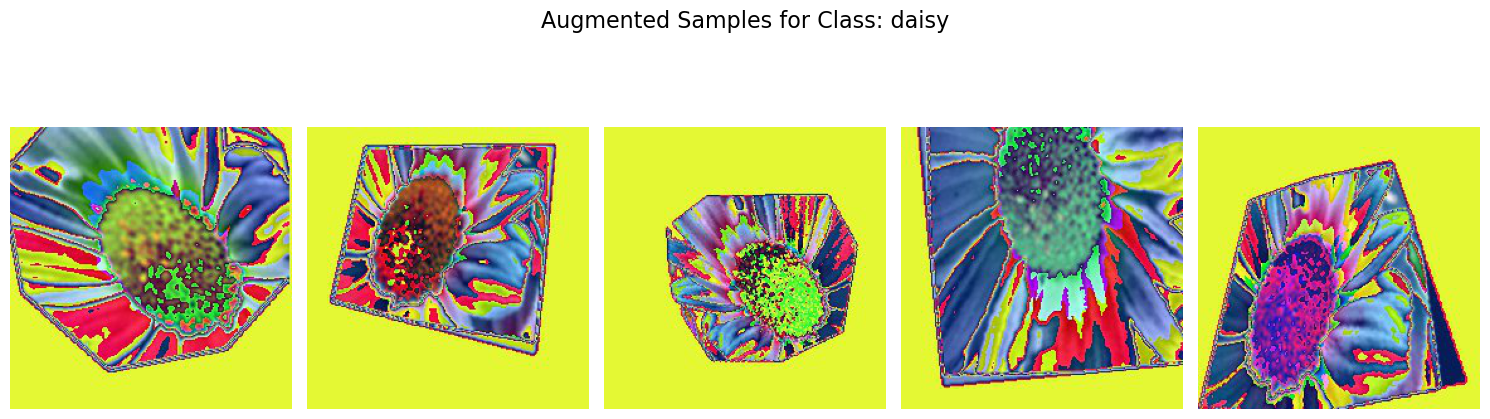

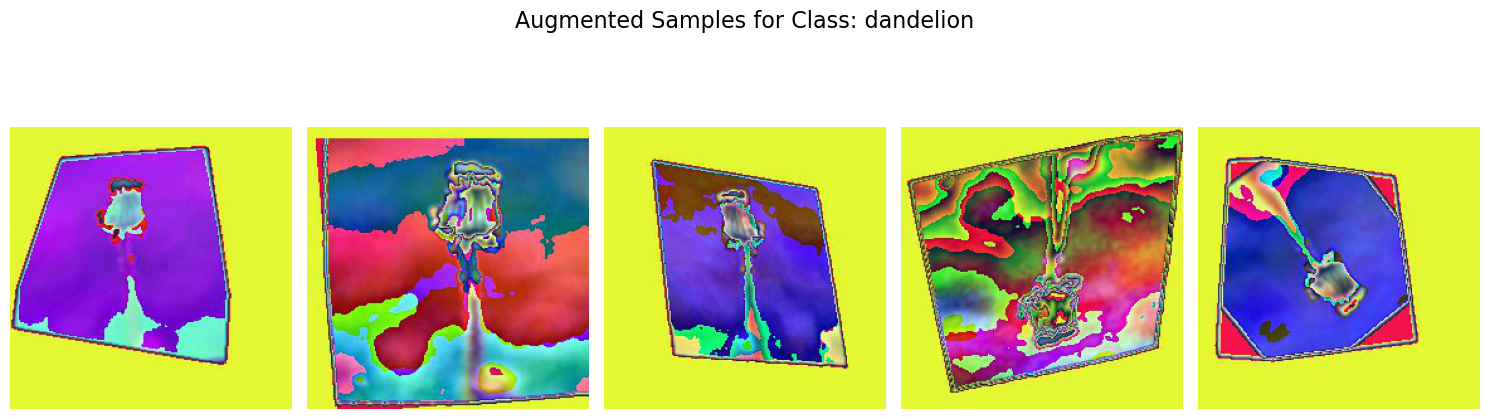

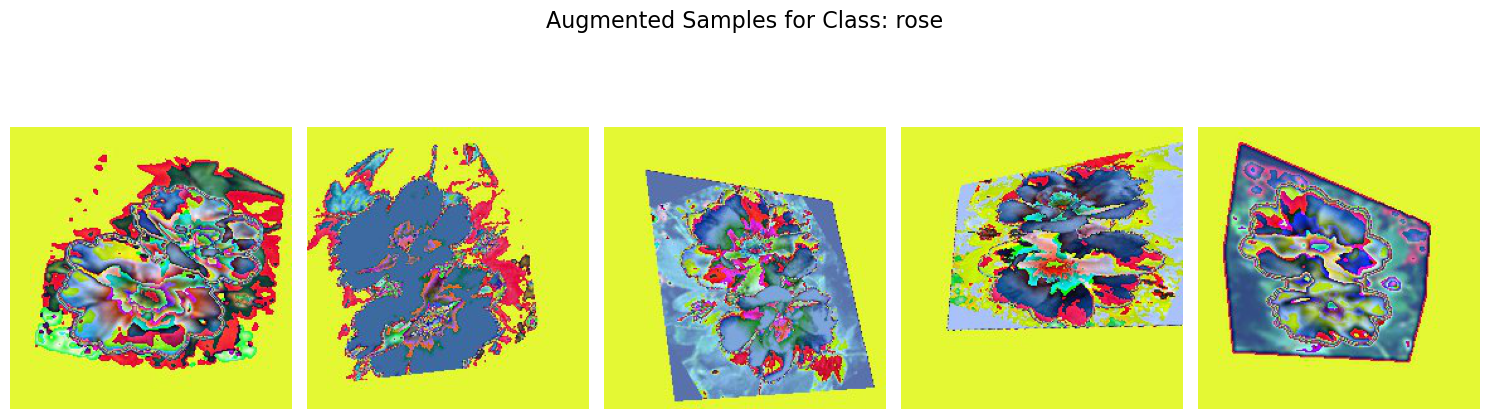

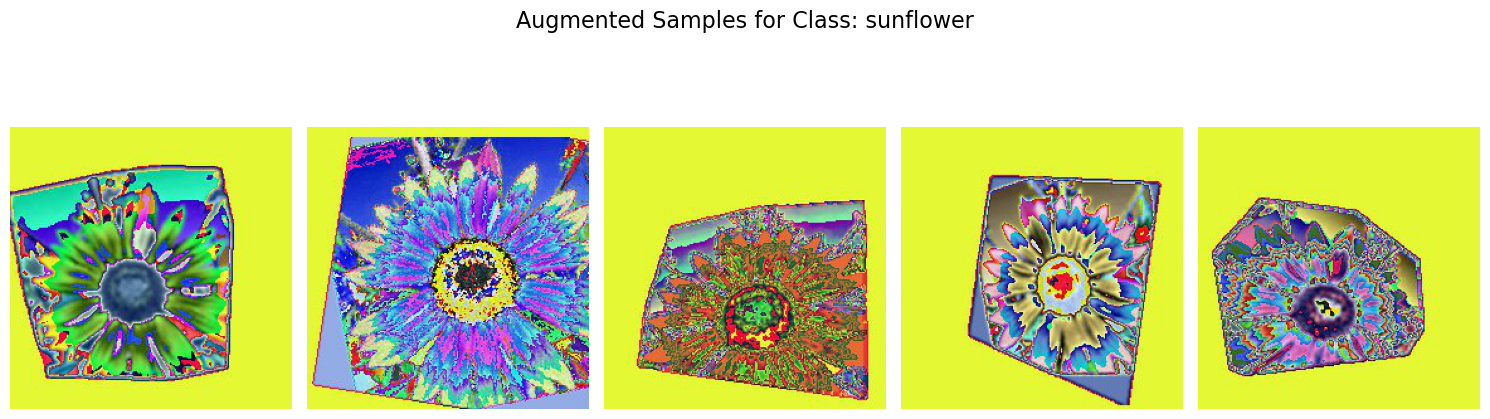

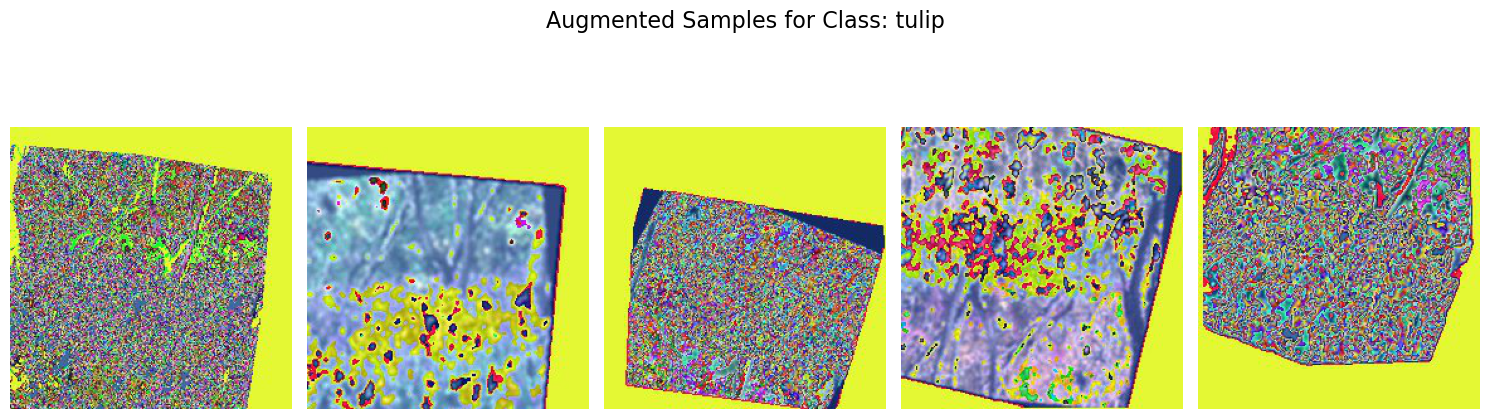

In [3]:
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

# Path to the augmented dataset
augmented_data_dir = r"augmented_train"

# Get the list of all classes in the augmented dataset
classes = os.listdir(augmented_data_dir)
if not classes:
    raise ValueError("No classes found in the augmented dataset. Check the directory path!")

# Loop through all classes and display 5 images for each
for selected_class in classes:
    class_path = os.path.join(augmented_data_dir, selected_class)
    sample_images = glob(os.path.join(class_path, "*.jpg"))[:5]  # Get up to 5 images

    if sample_images:
        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            plt.subplot(1, 5, i + 1)  # 5 images in a row
            plt.imshow(img)
            plt.axis("off")
        plt.suptitle(f"Augmented Samples for Class: {selected_class}", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No images found for the class '{selected_class}'. Check your augmented dataset directory.")

---

# Training

### Dataset Preparation and Splitting

In this step, we define a custom dataset class to handle loading and preprocessing of images from the dataset. The class supports the application of transformations, such as resizing and normalization, to prepare the data for training and validation.


---

In [4]:
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class PreprocessedDataset(Dataset):
    def __init__(self, root, transformations=None):
        self.root = root
        self.transformations = transformations
        self.im_paths = glob(os.path.join(root, '**', '*.jpg'), recursive=True)

        if len(self.im_paths) == 0:
            raise ValueError(f"No images found in {root}. Please check your dataset path.")

        self.classes = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        img = Image.open(im_path).convert("RGB")
        label = os.path.basename(os.path.dirname(im_path))
        label_idx = self.class_to_idx[label]

        if self.transformations:
            img = self.transformations(image=np.array(img))['image']

        return img, label_idx


## Training Class Definition

The `CustomTrainer` class handles the training and validation processes, including:
- Training and validation loops.
- Calculating metrics such as accuracy and F1-score.
- Saving model checkpoints and managing early stopping.


In [8]:
import torch
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.functional import accuracy
from torch.amp import GradScaler, autocast
import os
import json
from tqdm import tqdm

class CustomTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device, lr_scheduler=None, epochs=20, patience=5, save_path="best_model.pth", stats_path="training_stats.json"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.lr_scheduler = lr_scheduler
        self.epochs = epochs
        self.patience = patience
        self.save_path = save_path
        self.stats_path = stats_path
        self.f1_metric = MulticlassF1Score(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
        self.scaler = GradScaler(enabled=True)
        self.stats = {"train": [], "val": []}

    def save_checkpoint(self, epoch):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'lr_scheduler_state_dict': self.lr_scheduler.state_dict() if self.lr_scheduler else None,
            'stats': self.stats,
        }
        torch.save(checkpoint, "checkpoint.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}.")

    def load_checkpoint(self):
        checkpoint = torch.load("checkpoint.pth")
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.lr_scheduler and 'lr_scheduler_state_dict' in checkpoint:
            self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
        self.stats = checkpoint.get('stats', {"train": [], "val": []})
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}.")
        return start_epoch

    def train_one_epoch(self):
        self.model.train()
        total_loss, total_acc, total_f1 = 0, 0, 0

        for imgs, labels in tqdm(self.train_loader, desc="Training"):
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()

            with autocast(device_type="cuda"):
                preds = self.model(imgs)
                loss = self.criterion(preds, labels)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            total_acc += accuracy(preds, labels, task="multiclass", num_classes=self.f1_metric.num_classes).item()
            total_f1 += self.f1_metric(preds, labels).item()

        return total_loss / len(self.train_loader), total_acc / len(self.train_loader), total_f1 / len(self.train_loader)

    def validate_one_epoch(self):
        self.model.eval()
        total_loss, total_acc, total_f1 = 0, 0, 0

        with torch.no_grad():
            for imgs, labels in tqdm(self.val_loader, desc="Validating"):
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                preds = self.model(imgs)
                loss = self.criterion(preds, labels)

                total_loss += loss.item()
                total_acc += accuracy(preds, labels, task="multiclass", num_classes=self.f1_metric.num_classes).item()
                total_f1 += self.f1_metric(preds, labels).item()

        return total_loss / len(self.val_loader), total_acc / len(self.val_loader), total_f1 / len(self.val_loader)

    def save_stats(self):
        with open(self.stats_path, "w") as f:
            json.dump(self.stats, f, indent=4)
        print("Training statistics saved.")

    def train(self):
        start_epoch = 0
        if os.path.exists("checkpoint.pth"):
            start_epoch = self.load_checkpoint()

        best_val_f1 = max([val['f1'] for val in self.stats["val"]], default=0)
        no_improve_epochs = 0

        for epoch in range(start_epoch, self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            train_loss, train_acc, train_f1 = self.train_one_epoch()
            val_loss, val_acc, val_f1 = self.validate_one_epoch()

            self.stats["train"].append({"loss": train_loss, "accuracy": train_acc, "f1": train_f1})
            self.stats["val"].append({"loss": val_loss, "accuracy": val_acc, "f1": val_f1})

            self.save_stats()

            print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save(self.model.state_dict(), self.save_path)
                print("Model saved based on F1 Score!")
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                print(f"No improvement for {no_improve_epochs} epoch(s).")

                if no_improve_epochs >= 1:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] *= 0.1
                    print("Learning Rate reduced by a factor of 10.")

                if no_improve_epochs >= self.patience:
                    print("Early stopping triggered!")
                    break

            if self.lr_scheduler:
                self.lr_scheduler.step()


## Model Training

We use the **MobileNetV3 Large 100** architecture for training, leveraging transfer learning with pretrained weights. The model is fine-tuned to classify images based on the provided dataset. The training process in `train.py` includes the following features:

- **Dataset Splitting**: The dataset is split into 80% for training and 20% for validation using PyTorch's `random_split`.  
- **Optimizer**: Adam optimizer with a learning rate of `1e-3` and weight decay of `1e-4`.  
- **Learning Rate Scheduling**: Cosine Annealing Warm Restarts is used to dynamically adjust the learning rate during training.  
- **Early Stopping**: Handled by the `CustomTrainer` class in conjunction with validation metrics, with a patience of 2 epochs.  
- **Checkpointing**: The best model based on validation F1 score is saved automatically during training.  
- **Mixed Precision Training**: Enabled in the `CustomTrainer` for efficient computations and reduced memory consumption.  
- **Training and Validation Statistics**: Metrics such as loss, accuracy, and F1 score are computed and logged for both training and validation sets at the end of each epoch.  
- **Batch Processing**: Data is processed in batches of size 32 for both training and validation datasets.


In [10]:
import timm
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
# إعداد التحويلات
mean, std, size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

# تحميل البيانات
train_dataset = PreprocessedDataset(root="augmented_train", transformations=transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# إعداد النموذج
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("mobilenetv3_large_100", pretrained=True, num_classes=len(train_dataset.classes)).to(device)

# فك التجميد لتدريب جميع الطبقات
for param in model.parameters():
    param.requires_grad = True

# المُحسن والجدولة
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# كلاس التدريب
trainer = CustomTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=torch.nn.CrossEntropyLoss(),
    device=device,
    lr_scheduler=lr_scheduler,
    epochs=20,
    save_path="best_model.pth",
    stats_path="training_stats.json",
    patience=2
)

# بدء التدريب
trainer.train()



Epoch 1/20


Validating: 100%|██████████| 189/189 [00:58<00:00,  3.24it/s]


Training statistics saved.
Train Loss: 1.1601, Accuracy: 0.6308, F1: 0.6094
Val Loss: 0.6365, Accuracy: 0.7598, F1: 0.7425
Model saved based on F1 Score!

Epoch 2/20


Validating: 100%|██████████| 189/189 [00:18<00:00, 10.50it/s]


Training statistics saved.
Train Loss: 0.5963, Accuracy: 0.7835, F1: 0.7671
Val Loss: 0.5876, Accuracy: 0.7873, F1: 0.7691
Model saved based on F1 Score!

Epoch 3/20


Validating: 100%|██████████| 189/189 [00:18<00:00, 10.49it/s]


Training statistics saved.
Train Loss: 0.4330, Accuracy: 0.8447, F1: 0.8317
Val Loss: 0.5483, Accuracy: 0.8063, F1: 0.7893
Model saved based on F1 Score!

Epoch 4/20


Validating: 100%|██████████| 189/189 [00:15<00:00, 12.18it/s]


Training statistics saved.
Train Loss: 0.3126, Accuracy: 0.8869, F1: 0.8767
Val Loss: 0.6112, Accuracy: 0.8057, F1: 0.7883
No improvement for 1 epoch(s).
Learning Rate reduced by a factor of 10.

Epoch 5/20


Validating: 100%|██████████| 189/189 [00:19<00:00,  9.79it/s]


Training statistics saved.
Train Loss: 0.2214, Accuracy: 0.9205, F1: 0.9117
Val Loss: 0.5902, Accuracy: 0.8116, F1: 0.7933
Model saved based on F1 Score!

Epoch 6/20


Validating: 100%|██████████| 189/189 [00:18<00:00, 10.48it/s]


Training statistics saved.
Train Loss: 0.1264, Accuracy: 0.9541, F1: 0.9474
Val Loss: 0.4838, Accuracy: 0.8547, F1: 0.8431
Model saved based on F1 Score!

Epoch 7/20


Validating: 100%|██████████| 189/189 [00:16<00:00, 11.51it/s]


Training statistics saved.
Train Loss: 0.0609, Accuracy: 0.9797, F1: 0.9768
Val Loss: 0.5394, Accuracy: 0.8558, F1: 0.8415
No improvement for 1 epoch(s).
Learning Rate reduced by a factor of 10.

Epoch 8/20


Validating: 100%|██████████| 189/189 [00:15<00:00, 12.34it/s]


Training statistics saved.
Train Loss: 0.0283, Accuracy: 0.9904, F1: 0.9887
Val Loss: 0.5756, Accuracy: 0.8611, F1: 0.8493
Model saved based on F1 Score!

Epoch 9/20


Validating: 100%|██████████| 189/189 [00:15<00:00, 12.36it/s]


Training statistics saved.
Train Loss: 0.0122, Accuracy: 0.9967, F1: 0.9962
Val Loss: 0.5473, Accuracy: 0.8734, F1: 0.8628
Model saved based on F1 Score!

Epoch 10/20


Validating: 100%|██████████| 189/189 [00:19<00:00,  9.82it/s]


Training statistics saved.
Train Loss: 0.0062, Accuracy: 0.9984, F1: 0.9980
Val Loss: 0.5482, Accuracy: 0.8747, F1: 0.8648
Model saved based on F1 Score!

Epoch 11/20


Validating: 100%|██████████| 189/189 [00:15<00:00, 12.30it/s]


Training statistics saved.
Train Loss: 0.7015, Accuracy: 0.7638, F1: 0.7479
Val Loss: 0.6330, Accuracy: 0.7911, F1: 0.7724
No improvement for 1 epoch(s).
Learning Rate reduced by a factor of 10.

Epoch 12/20


Validating: 100%|██████████| 189/189 [00:15<00:00, 12.30it/s]

Training statistics saved.
Train Loss: 0.3602, Accuracy: 0.8671, F1: 0.8552
Val Loss: 0.5947, Accuracy: 0.8022, F1: 0.7872
No improvement for 2 epoch(s).
Learning Rate reduced by a factor of 10.
Early stopping triggered!


---

## Model Evaluation

The evaluation process for the trained model focuses on measuring performance and generating insights using the validation dataset. The key steps and features of the evaluation process include:

- **Model Loading**: The trained model is loaded from the saved checkpoint file (`best_model.pth`) for evaluation.  
- **Validation Dataset**: The same validation dataset used during training is utilized to ensure consistency in evaluation.  
- **Batch Processing**: Data is processed in batches of size 32 for efficient evaluation.  
- **Confusion Matrix Calculation**: A confusion matrix is generated using `torchmetrics.ConfusionMatrix` to visualize the model's performance across all classes.  
- **Prediction Aggregation**: Predictions and true labels from all validation batches are collected and used to compute the confusion matrix.  
- **Metrics Reporting**: The confusion matrix is displayed in the console for quick analysis and saved as a CSV file (`confusion_matrix.csv`) for further analysis.  
- **No Training Involved**: The evaluation script strictly performs inference without any weight updates or backpropagation.  


In [13]:
import torch
from torchmetrics.classification import MulticlassConfusionMatrix
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# تحميل النموذج المحفوظ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=len(train_dataset.classes)).to(device)
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

# إنشاء DataLoader للبيانات
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# إنشاء مصفوفة الالتباس
confusion_matrix = MulticlassConfusionMatrix(num_classes=len(train_dataset.classes)).to(device)

all_preds = []
all_labels = []

# التقييم على مجموعة التحقق
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Evaluating"):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        preds = torch.argmax(preds, dim=1)
        
        all_preds.append(preds)
        all_labels.append(labels)

# تجميع القيم لحساب المصفوفة
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
conf_matrix = confusion_matrix(all_labels, all_preds)

# عرض مصفوفة الالتباس
print("Confusion Matrix:")
print(conf_matrix.cpu().numpy())

# حفظ المصفوفة كملف CSV
np.savetxt("confusion_matrix.csv", conf_matrix.cpu().numpy(), delimiter=",")


Evaluating: 100%|██████████| 189/189 [01:22<00:00,  2.29it/s]

Confusion Matrix:
[[ 942   33   26   22   37]
 [  46 1291   31   27   37]
 [  22   18  935   39   99]
 [  31   32   43  984   56]
 [  25   21   81   31 1133]]


---

### Training and Validation Analysis

The model's performance is analyzed using training and validation metrics saved in a JSON file (`training_stats.json`). The key steps and processes involved are as follows:

- **Data Source**: The statistics for each epoch are extracted from the JSON file. The file contains metrics for both training and validation, including:
  - **Loss**: A measure of how well the model fits the data.
  - **Accuracy**: The percentage of correct predictions.
  - **F1 Score**: The harmonic mean of precision and recall, indicating the balance between false positives and false negatives.

#### Key Features of Analysis
- **Best Metric Extraction**:
  - The best value for each metric (loss, accuracy, and F1 score) is identified.
  - The epoch corresponding to each best value is also determined for detailed analysis.

- **Visual Representation**:
  - **Loss Curves**: Training and validation loss are plotted across epochs to monitor overfitting or underfitting.
  - **Accuracy Curves**: Trends in accuracy are visualized to assess generalization performance.
  - **F1 Score Curves**: F1 scores are plotted to evaluate precision-recall balance.

#### Visualizations
The following plots were generated to summarize the model's performance over epochs:
1. **Training and Validation Loss**:
   - Highlights how well the model minimizes errors during training and testing.
2. **Training and Validation Accuracy**:
   - Displays the percentage of correct predictions and tracks the model's generalization capability.
3. **Training and Validation F1 Score**:
   - Provides a detailed evaluation of the balance between precision and recall.

Each visualization enables easier interpretation of the model's learning curve and helps identify potential issues like overfitting or underfitting.


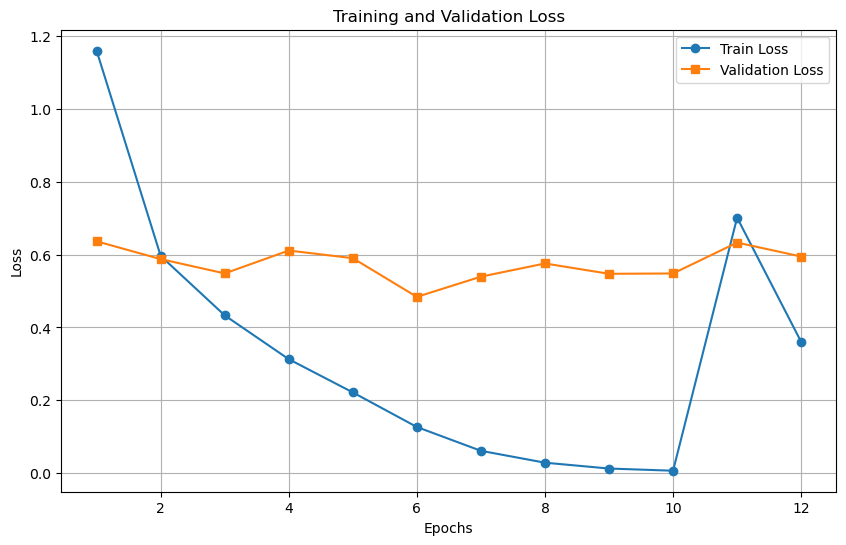

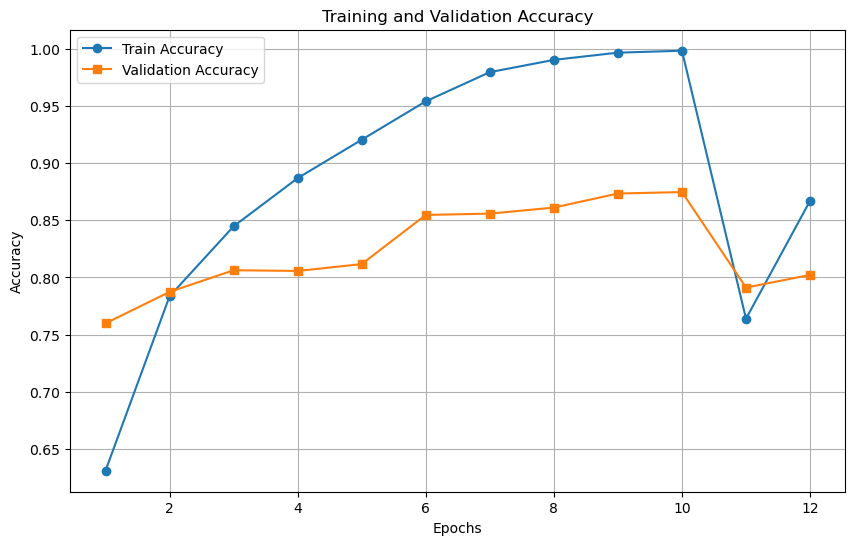

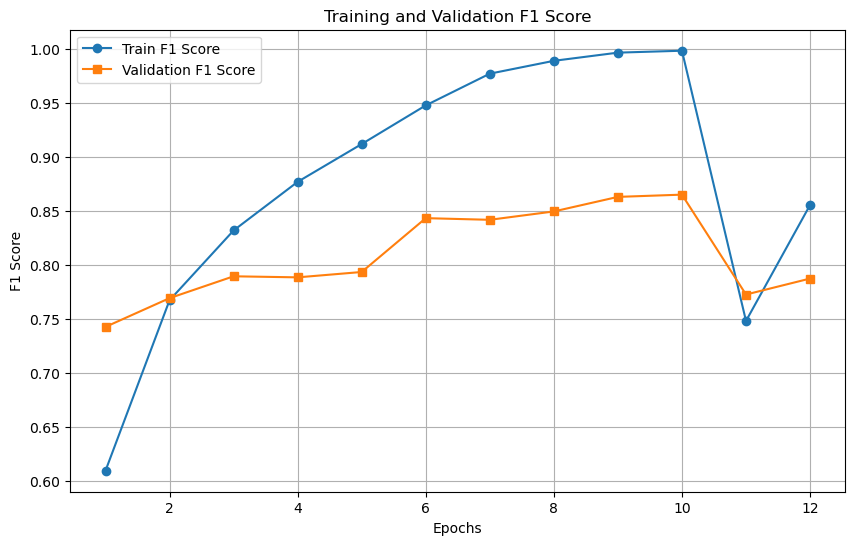

Best Statistics:
Best Train Loss: 0.0062 at Epoch 10
Best Validation Loss: 0.4838 at Epoch 6
Best Train Accuracy: 99.84% at Epoch 10
Best Validation Accuracy: 87.47% at Epoch 10
Best Train F1 Score: 0.9980 at Epoch 10
Best Validation F1 Score: 0.8648 at Epoch 10


In [18]:
import json
import matplotlib.pyplot as plt

# Load training statistics from JSON file
stats_file = "training_stats.json"
with open(stats_file, "r") as f:
    stats = json.load(f)

# Extract statistics for training and validation
train_loss = [epoch["loss"] for epoch in stats["train"]]
val_loss = [epoch["loss"] for epoch in stats["val"]]
train_acc = [epoch["accuracy"] for epoch in stats["train"]]
val_acc = [epoch["accuracy"] for epoch in stats["val"]]
train_f1 = [epoch["f1"] for epoch in stats["train"]]
val_f1 = [epoch["f1"] for epoch in stats["val"]]
epochs = list(range(1, len(train_loss) + 1))

# Find best values and their corresponding epochs
best_train_loss = min(train_loss)
best_train_loss_epoch = train_loss.index(best_train_loss) + 1

best_val_loss = min(val_loss)
best_val_loss_epoch = val_loss.index(best_val_loss) + 1

best_train_acc = max(train_acc)
best_train_acc_epoch = train_acc.index(best_train_acc) + 1

best_val_acc = max(val_acc)
best_val_acc_epoch = val_acc.index(best_val_acc) + 1

best_train_f1 = max(train_f1)
best_train_f1_epoch = train_f1.index(best_train_f1) + 1

best_val_f1 = max(val_f1)
best_val_f1_epoch = val_f1.index(best_val_f1) + 1

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_f1, label="Train F1 Score", marker="o")
plt.plot(epochs, val_f1, label="Validation F1 Score", marker="s")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# Print Best Statistics
print("Best Statistics:")
print(f"Best Train Loss: {best_train_loss:.4f} at Epoch {best_train_loss_epoch}")
print(f"Best Validation Loss: {best_val_loss:.4f} at Epoch {best_val_loss_epoch}")
print(f"Best Train Accuracy: {best_train_acc*100:.2f}% at Epoch {best_train_acc_epoch}")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}% at Epoch {best_val_acc_epoch}")
print(f"Best Train F1 Score: {best_train_f1:.4f} at Epoch {best_train_f1_epoch}")
print(f"Best Validation F1 Score: {best_val_f1:.4f} at Epoch {best_val_f1_epoch}")


### Confusion Matrix Visualization

To evaluate the performance of the trained model, we analyzed the confusion matrix. The confusion matrix provides detailed insights into the classification results by comparing the true labels with the predicted labels. This helps identify patterns of misclassification and model performance across different classes.

#### Process Details

- **Data Source**: The confusion matrix is stored in a CSV file named `confusion_matrix.csv`.
- **Visualization**:
  - The confusion matrix is represented as a heatmap using Seaborn and Matplotlib for better readability.
  - Each cell in the matrix corresponds to the number of instances where the true label is classified as the predicted label.

#### Key Features of the Analysis
1. **True Positive (Diagonal Values)**:
   - Indicates correct classifications for each class.
2. **Misclassification Patterns**:
   - Helps identify which classes are being confused and the frequency of such errors.
3. **Heatmap Styling**:
   - Annotated with values to make it visually interpretable.
   - The color intensity represents the magnitude of values, making trends easily noticeable.

#### Use Case
The confusion matrix provides critical insights for:
- Adjusting hyperparameters to reduce specific misclassification types.
- Enhancing the training dataset with more examples of frequently misclassified classes.
- Fine-tuning the model to improve overall accuracy.


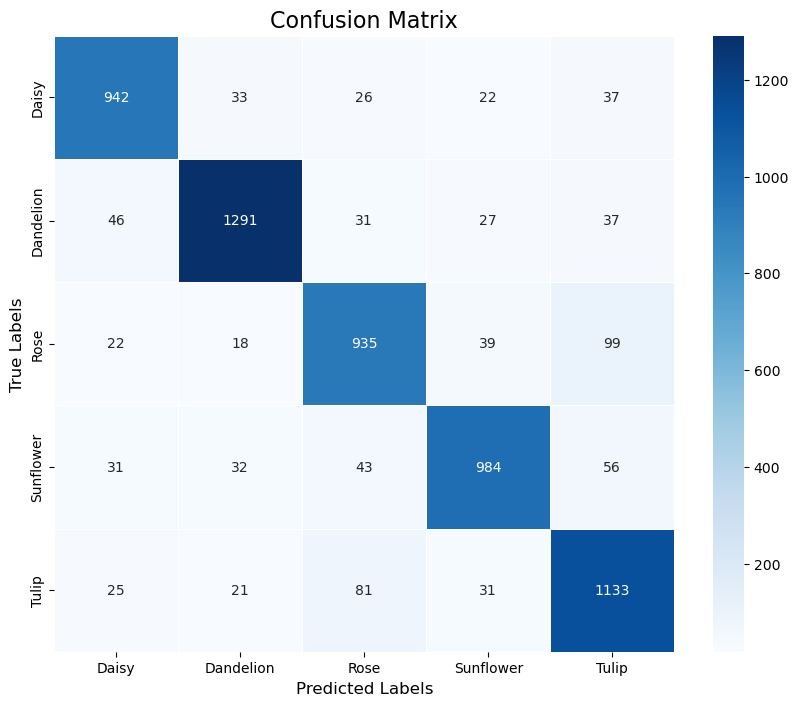

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the confusion matrix from CSV file
confusion_matrix_file = "confusion_matrix.csv"
conf_matrix = pd.read_csv(confusion_matrix_file, header=None)

# Ensure the matrix values are integers
conf_matrix = conf_matrix.astype(int)

# Class names
class_names = ["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"]

# Plot the confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


### Converting the Model from `.pth` to `.onnx`

When working with machine learning models, particularly those trained using frameworks like PyTorch, you might encounter situations where you need to deploy the model in an environment that doesn't support PyTorch natively. In such cases, converting the model to the ONNX (Open Neural Network Exchange) format can be very beneficial. 

#### Why Convert from `.pth` to `.onnx`?

1. **Cross-Platform Compatibility**: 
   - ONNX is designed to be an open standard for representing machine learning models. By converting your model to ONNX, you ensure that it can be run on multiple platforms and devices, such as TensorFlow, Caffe2, and other frameworks, as well as on edge devices that may not support PyTorch directly.

2. **Performance Optimization**:
   - ONNX models can be optimized for inference. Using tools like ONNX Runtime, you can take advantage of hardware accelerators (like GPUs or specialized hardware) to speed up the model’s inference process. This is especially useful in production environments where performance is critical.

3. **Interoperability**:
   - Converting models to ONNX makes it easier to integrate them into various applications, even if those applications are built with different machine learning frameworks. It allows the model to be used in a wider array of contexts.

4. **Model Deployment**:
   - Once a model is converted to ONNX, it can be easily deployed in cloud environments, on mobile devices, or even in browsers with support for WebAssembly (WASM) or other runtime environments that support ONNX.

5. **Standardization**:
   - The ONNX format is widely adopted by many machine learning communities and tools, making it a reliable and standardized way to store and transport models across various platforms.

#### Key Advantages of Using ONNX

1. **Hardware Acceleration**:
   - ONNX models are supported by optimized backends like ONNX Runtime, which can automatically utilize hardware accelerators, improving model inference speed across different devices.

2. **Ease of Export**:
   - Converting a PyTorch model to ONNX is straightforward. With just a few lines of code, you can export your trained model to an ONNX file that can then be used in a variety of deployment scenarios.

3. **Reduced Dependency on Framework-Specific Libraries**:
   - Once converted, an ONNX model no longer requires the original training framework for inference. This reduces the dependency on libraries like PyTorch, TensorFlow, etc., simplifying the deployment process.

4. **Future-proofing**:
   - The ONNX ecosystem is continuously evolving, with many new features and tools being developed to support the latest advancements in machine learning. By using ONNX, you future-proof your models for upcoming technologies and improvements.

#### Summary of the Process

- **Exporting the Model**: The model is first saved in the `.pth` format, which is the standard for PyTorch models. However, to make it more portable and compatible with various deployment platforms, the model is converted into the `.onnx` format. 
- **Advantages of ONNX**: After conversion, the model can be deployed more easily across different platforms and environments while benefiting from optimizations that improve performance.


In [1]:
import torch
import timm
# تحميل النموذج
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "mobilenetv3_large_100"
num_classes = 5  # عدد الفئات
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

# تحميل الأوزان مع تجنب التحذير
model.load_state_dict(torch.load("best_model.pth", map_location=device, weights_only=True))
model.to(device)  # تأكد من نقل النموذج إلى نفس الجهاز
model.eval()

# مثال لبيانات الإدخال (يجب أن يكون نفس حجم البيانات المستخدمة أثناء التدريب)
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # تأكد من أن البيانات على نفس الجهاز

# تصدير النموذج إلى صيغة ONNX
onnx_file_path = "model.onnx"
torch.onnx.export(
    model,  # النموذج
    dummy_input,  # بيانات الإدخال الوهمية
    onnx_file_path,  # اسم ملف ONNX
    export_params=True,  # تصدير أوزان النموذج
    opset_version=11,  # إصدار ONNX (11 هو إصدار شائع مدعوم)
    do_constant_folding=True,  # تحسين التصدير عن طريق طي الثوابت
    input_names=["input"],  # أسماء المدخلات
    output_names=["output"],  # أسماء المخرجات
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}  # دعم الدُفعات المتغيرة
)

print(f"Model Saved to: {onnx_file_path}")

c:\Users\Farouz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Saved to: model.onnx


---

## Conclusion

### Final Summary
This project explored the development of a deep learning model for flower classification, covering key steps such as data preprocessing, model training, evaluation, and visualization. The results highlight the potential for real-world applications in agriculture and environmental studies.

### Challenges and Future Work
- **Challenges:** Mentioning any challenges faced during the project and how they were resolved adds depth to the conclusion.
- **Future Work:** Future improvements could include enhancing model accuracy, expanding the dataset to cover more flower types, or optimizing the model for deployment on mobile or edge devices.

### Acknowledgments
A brief acknowledgment of any individuals, teams, or resources that supported this work can add a personal touch. For example:  
"I would like to express my gratitude to [team, mentor, or platform] for their guidance and support throughout this project."

### Potential Extensions
This project has room for further development. Here are some ideas:
- Integrating the model into a mobile app to identify flowers in real-time.
- Expanding the model to classify other types of plants or natural objects.
- Applying the approach to related fields like pest detection or crop health monitoring.

---

By concluding with these points, this project demonstrates not only its success but also its relevance to future innovations in machine learning and its applications.
